In [1]:
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
#!{sys.executable} -m pip install tensorflow-gpu==2.4
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/bhawks/.conda/envs/dune-1dcnn/lib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

'export' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
string = 'tck_'

In [4]:
for i in range(nticks):
    print(combined_noise[string+str(i)].astype(np.int16))

NameError: name 'nticks' is not defined

In [ ]:
extract_wave(combined_noise)

NameError: name 'extract_wave' is not defined

In [5]:
wireplane = "V"
sig_name = wireplane+"-signal"
cln_name = wireplane+"-clnsig"
np.random.seed(42)
nticks = 200
max_mels = 11000
min_edp = 50000
ADC_MIN = 3
ADC_MAX = 10
waveform_scaler = StandardScaler()

def extract_wave(data):
    string = 'tck_'
    waveforms = []
    #Here I extract a column in each iteration and append to list
    for i in range(5):
        for k in range(nticks):
            waveforms.append(data[string+str(k)].astype(np.int16))
    #convert to numpy ndarray
    waveforms = np.array(waveforms).astype(np.int16)
    #since raws and columns are inverted we need to transpose it
    return np.transpose(waveforms)

def extract_peak(data):
    #extract index of peak
    idx = np.array([data['stp0'], data['adc0'], data['stp1'], data['adc1'], data['stp2'], data['adc2'], data['stp3'], data['adc3'], data['stp4'], data['adc4']])
    #same as before
    return np.transpose(idx)

def extract_peak_info(data):
    peaks_pos = [data['stp0'], data['stp1'], data['stp2'], data['stp3'], data['stp4']]
    adcs = [data['adc0'], data['adc1'], data['adc2'], data['adc3'], data['adc4']]
    return np.array(peaks_pos).T, np.array(adcs).T

def extract_nel_info(data):
    nels = [data['nel0'], data['nel1'], data['nel2'], data['nel3'], data['nel4']]
    return np.array(nels).T

def extract_edp_info(data):
    edp = [data['edp0'], data['edp1'], data['edp2'], data['edp3'], data['edp4']]
    return np.array(edp).T

def filter_signals(data, clean_data, filter_adc_max=True):
    #edp_mask = np.all(extract_edp_info(data)>min_edp, axis = 1)
    #nel_mask = np.all(extract_nel_info(data)<max_mels, axis = 1)
    #pd.DataFrame(np.all(extract_edp_info(data)>min_edp, axis = 1)).describe()
    #print(edp_mask)
    #print(nel_mask)
    #filter_mask = nel_mask #np.logical_and(edp_mask,nel_mask) 
    filtered_data = data#[filter_mask]
    cln_filtered_data = clean_data#[filter_mask]
    
    filtered_peak = extract_peak_info(cln_filtered_data)[1]
    if filter_adc_max:
        peak_mask = np.any(filtered_peak>ADC_MIN, axis = 1)
        peak_mask &= np.any(filtered_peak<ADC_MAX, axis = 1)
    else:
        peak_mask = np.any(filtered_peak>ADC_MIN, axis = 1)
    
    filtered_data = filtered_data[peak_mask]
    cln_filtered_data = cln_filtered_data[peak_mask]
    
    return filtered_data, cln_filtered_data, filtered_peak

def get_std_waveforms(data):
    #Extract and scale waveform data (passthrough rn)
    raw_waveforms = extract_wave(data)
    #print(raw_waveforms) 
    #scaled_waveforms = waveform_scaler.fit_transform(raw_waveforms)
    return raw_waveforms

In [6]:
#X = np.load("data/X_argoneut.npz")
#y = np.load("data/y_argoneut.npz")
#old_peak = np.load("peak_argoneut.npz")

#Load Training Data
path = "../../dunesnb/1dcnn/train/train/nu_cc/"
path2 = "../../dunesnb/1dcnn/train/train/nu_es/"
filenames1 = [path+f for f in listdir(path) if (isfile(join(path, f)) and sig_name in f)]
clean_filenames1 = [path+f for f in listdir(path) if (isfile(join(path, f)) and cln_name in f)]
filenames2 = [path2+f for f in listdir(path2) if (isfile(join(path2, f)) and sig_name in f)]
clean_filenames2 = [path2+f for f in listdir(path2) if (isfile(join(path2, f)) and cln_name in f)]

filenames =  filenames1+filenames2
clean_filenames = clean_filenames1+clean_filenames2

combined_data = np.concatenate([np.load(fname) for fname in filenames])
combined_clean_data = np.concatenate([np.load(fname) for fname in filenames])

noise_path = "../../dunesnb/1dcnn/train/train/noise/"
noise_filenames = [f for f in listdir(noise_path) if (isfile(join(noise_path, f)) and sig_name in f)]
#print(noise_filenames)
noise_clean_filenames = [f for f in listdir(noise_path) if (isfile(join(noise_path, f)) and cln_name in f)]

combined_noise = np.concatenate([np.load(noise_path+fname) for fname in noise_filenames])
#print(combined_noise)
#combined_clean_noise = np.concatenate([np.load(noise_path+fname) for fname in noise_clean_filenames])

In [7]:
2000/200

10.0

In [8]:
a = extract_wave(combined_data)

In [9]:
a.shape

(231744, 1000)

In [10]:
combined_data.shape

(231744,)

# Train/Noise Data Preprocessing



In [11]:
from sklearn.utils import shuffle
print("Unfiltered:" + str(combined_data.shape[0]))
#Filter out tiny signals < ADC_MIN, but leave big signals to test on (> ADC_MAX)
combined_data, combined_clean_data, peak = filter_signals(combined_data, combined_clean_data, False)
print("> ADC_MIN:" + str(combined_data.shape[0]))

#split train and test sets (~50k ea before filtering) 
combined_data, x_test_data, combined_clean_data, x_test_clean  = train_test_split(
    combined_data, combined_clean_data, test_size=0.5, shuffle=True
)
print("Train Split:" + str(combined_data.shape[0]))
#filter data and extract waveforms of filtered data
combined_data, combined_clean_data, peak = filter_signals(combined_data, combined_clean_data, True)
signal_waveforms = get_std_waveforms(combined_data)
print("Train Split Filtered ADC_MIN < x < ADC_MAX:" + str(combined_data.shape[0]))
#extract waveforms of noise
noise_waveforms = get_std_waveforms(combined_noise)
#extract waveforms of test data
test_signal_waveforms = get_std_waveforms(x_test_data)
print("Test Set:" + str(test_signal_waveforms.shape[0]))

Unfiltered:231744
> ADC_MIN:130731
Train Split:65365
Train Split Filtered ADC_MIN < x < ADC_MAX:62239
Test Set:65366


In [12]:
print(test_signal_waveforms.shape, signal_waveforms.shape, noise_waveforms.shape)

(65366, 1000) (62239, 1000) (108600, 1000)


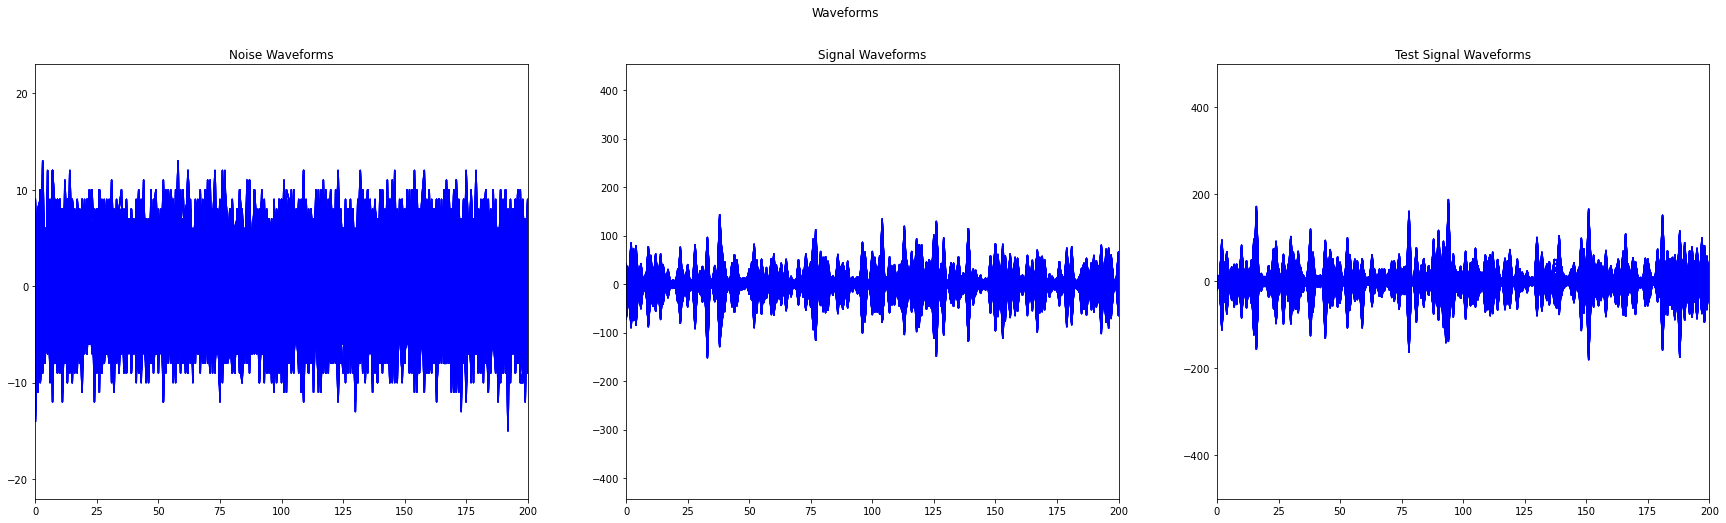

In [13]:
start_for_plot = 0
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))
fig.suptitle('Waveforms')
ax1.plot(noise_waveforms,color='blue')
ax1.set_xlim(start_for_plot, start_for_plot + 200)
ax1.set_title("Noise Waveforms")

ax2.plot(signal_waveforms,color='blue')
ax2.set_xlim(start_for_plot, start_for_plot + 200)
ax2.set_title("Signal Waveforms")

ax3.plot(test_signal_waveforms,color='blue')
ax3.set_xlim(start_for_plot, start_for_plot + 200)
ax3.set_title("Test Signal Waveforms")
ax3.set_ybound(-500, 500)
plt.show()

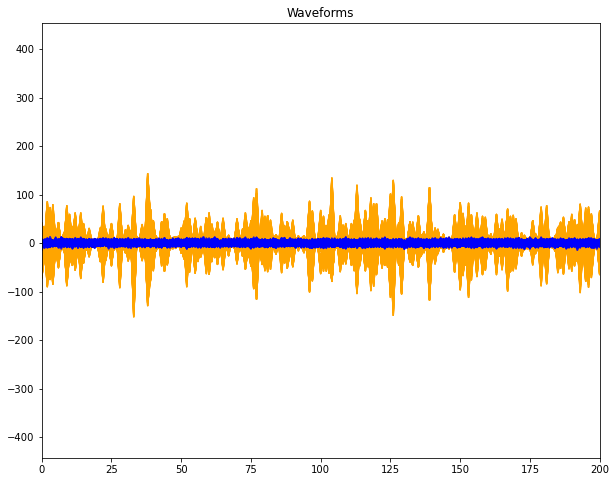

In [14]:
start_for_plot = 0
fig = plt.figure(figsize=(10, 8))
plt.plot(signal_waveforms,color='orange', alpha=0.7)
plt.plot(noise_waveforms,color='blue',alpha=0.3)
plt.xlim(start_for_plot, start_for_plot + 200)
plt.title("Waveforms")
plt.show()

In [15]:
#generate y data (assuming all radiologicals contain signal, all noise does not)
y_noise_full = np.zeros(noise_waveforms.shape[0])
y_signal = np.ones(signal_waveforms.shape[0])
y_test_signal = np.ones(test_signal_waveforms.shape[0])

# split test and train noise datasets (50k)
x_noise_train, x_noise_test, y_noise_train, y_noise_test = train_test_split(noise_waveforms, y_noise_full, test_size=0.5, shuffle=True)
#Shuffle signal waveforms to be safe
signal_waveforms, y_signal = shuffle(signal_waveforms,y_signal)
#Shuffle test waveformst to be safe
x_test, y_test = shuffle(test_signal_waveforms,y_test_signal)

In [16]:
print(x_noise_train.shape, signal_waveforms.shape, x_test.shape)

(54300, 1000) (62239, 1000) (65366, 1000)


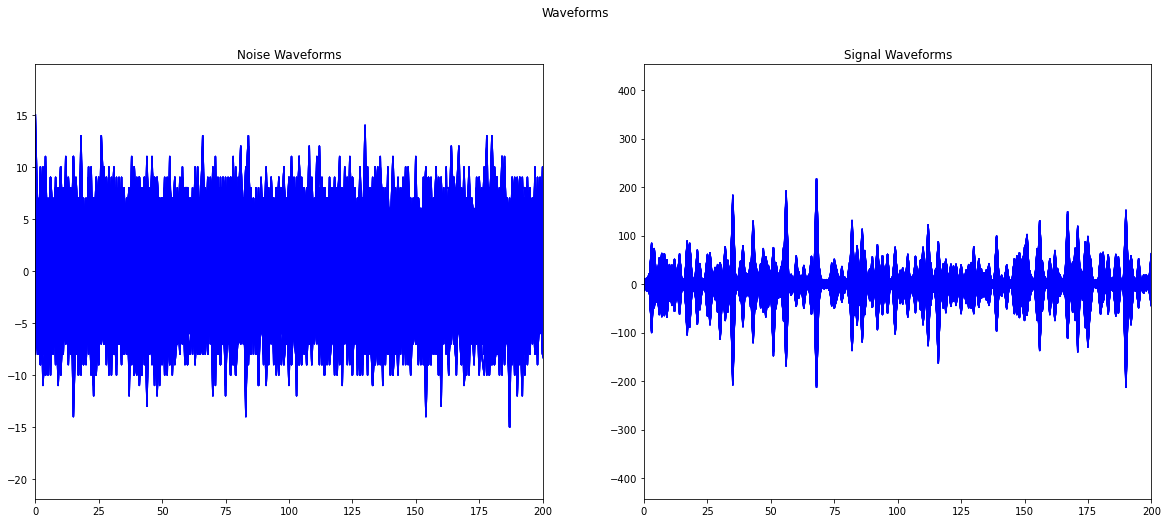

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Waveforms')
ax1.plot(x_noise_train, color='blue')
ax1.set_xlim(0, 200)
ax1.set_title("Noise Waveforms")

ax2.plot(signal_waveforms, color='blue')
ax2.set_xlim(0, 200)
ax2.set_title("Signal Waveforms")
plt.show()

In [18]:
#Select First n signal samples from (shuffled) set of signals where n = noise samples for balanced train set 
x_train = np.concatenate((signal_waveforms[:int(x_noise_train.shape[0])], x_noise_train))
y_train = np.concatenate((y_signal[:int(x_noise_train.shape[0])], y_noise_train))
x_test = np.concatenate((x_test[:int(x_noise_test.shape[0])], x_noise_test))
y_test = np.concatenate((y_test_signal[:int(x_noise_test.shape[0])], y_noise_test))


# extra train shuffle for good measure 
x_train, y_train = shuffle(x_train,y_train)
# extra test shuffle for good measure 
x_test, y_test = shuffle(x_test,y_test)
#split train and valid sets (40k train 10k valid) 
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=0.2, shuffle=True
)

In [19]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_valid.shape, y_valid.shape)

(86880, 1000) (86880,) (108600, 1000) (108600,) (21720, 1000) (21720,)


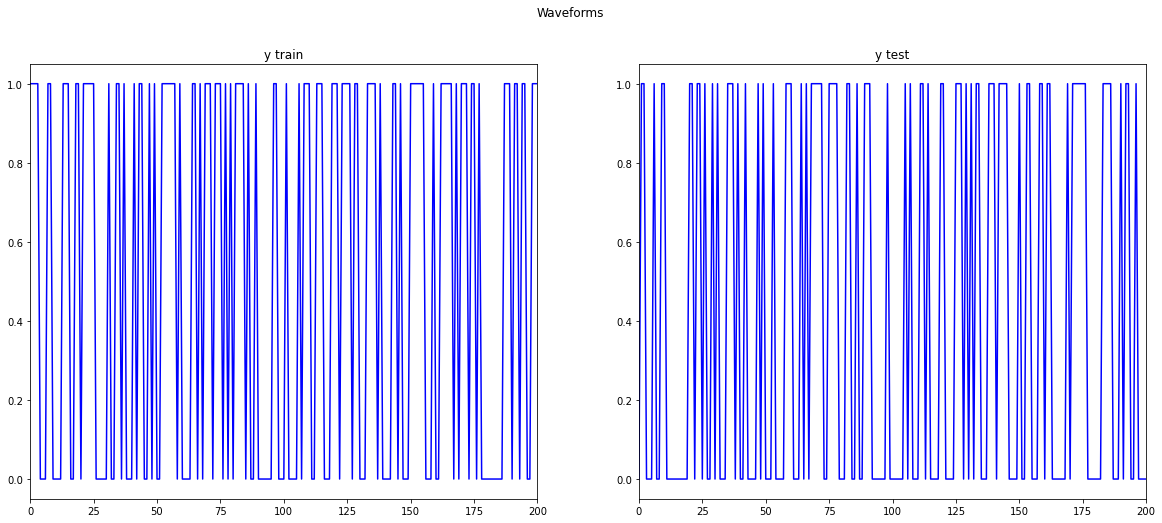

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Waveforms')
ax1.plot(y_train, color='blue')
ax1.set_xlim(0, 200)
ax1.set_title("y train")

ax2.plot(y_test, color='blue')
ax2.set_xlim(0, 200)
ax2.set_title("y test")
plt.show()

In [21]:
mean = x_train.mean()
std = x_train.std()

In [22]:
x_train_scaled = (x_train-mean)/std
x_valid_scaled = (x_valid-mean)/std
x_test_scaled = (x_test-mean)/std
#cc_x_test_scaled = (cc_x_test-mean)/std 
#es_x_test_scaled = (es_x_test-mean)/std 

In [23]:
print(x_train_scaled.shape, x_valid_scaled.shape, x_test_scaled.shape)

(86880, 1000) (21720, 1000) (108600, 1000)


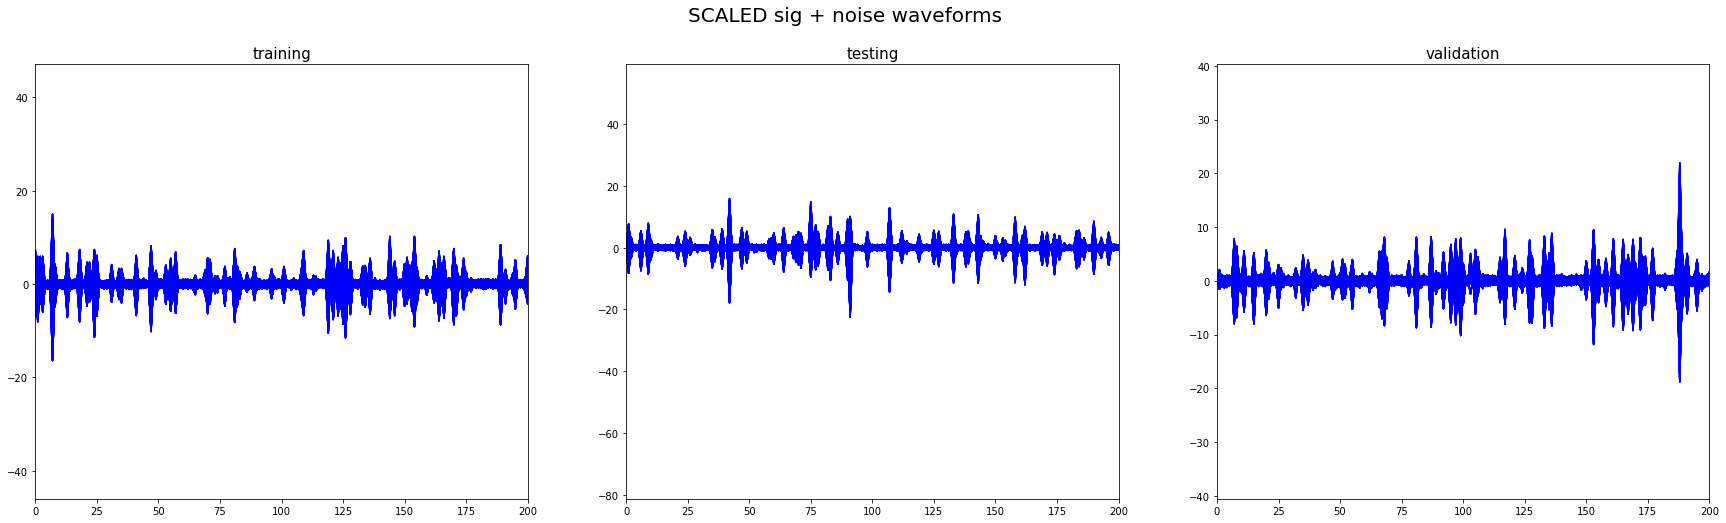

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))
fig.suptitle('SCALED sig + noise waveforms',fontsize=20)
ax1.plot(x_train_scaled, color='blue')
ax1.set_xlim(0, 200)
ax1.set_title("training", fontsize=15)

ax2.plot(x_test_scaled, color='blue')
ax2.set_xlim(0, 200)
ax2.set_title("testing", fontsize=15)

ax3.plot(x_valid_scaled, color='blue')
ax3.set_xlim(0, 200)
ax3.set_title("validation", fontsize=15)
plt.show()

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout, Dense,Flatten, AveragePooling1D
from tensorflow.keras.layers import Input,  UpSampling1D
from tensorflow.keras.models import Model
#from keras import backend as K

In [26]:
x_train_scaled[0].shape

(1000,)

In [27]:
for i in range(0,10):
    print(x_train_scaled[i].shape)

(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)


In [28]:
x_train_scaled.shape

(86880, 1000)

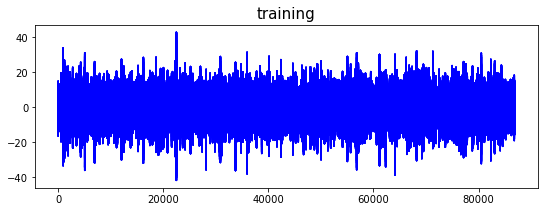

In [29]:
plt.figure(figsize=(9, 3))
plt.plot(x_train_scaled, color='blue')
#plt.xlim(0, 200)
plt.title("training", fontsize=15)
plt.show()

# Autoencoder

In [30]:
#from tensorflow.keras.models import load_model
#model = load_model("learn_models/Vplane_nu.h5")

In [31]:
#for i,layer in enumerate(model.layers):
#  print(i,layer.name)

In [32]:
time_periods = 1000

In [33]:
input_wave = Input(shape=(x_train_scaled.shape[1], 1)) 
x = Conv1D(filters=16, kernel_size=3, strides=2, activation = "relu", input_shape=(time_periods,1))(input_wave)
x =MaxPooling1D(pool_size=2)(x)
 
#third convolutional block
x = Conv1D(filters=32, kernel_size=5, strides=2,  activation = "relu")(x)
x = MaxPooling1D(pool_size=2)(x)

#forth convolutional block
encoded = Conv1D(filters=64, kernel_size=9, activation = "relu")(x)


x = Conv1D(filters=64, kernel_size=9, padding = "same", activation = "relu")(encoded)
x = UpSampling1D(6)(x)

x = Conv1D(filters=64, kernel_size=8, padding = "same", activation = "relu")(x)
x = UpSampling1D(4)(x)

x = Conv1D(filters=32, kernel_size=7,  activation = "relu")(x)
x = UpSampling1D(4)(x)
x = Conv1D(filters=16, kernel_size=7,   activation = "relu")(x)
x = UpSampling1D(4)(x)
x = Conv1D(filters=8, kernel_size=8,   activation = "relu")(x)
x = UpSampling1D(4)(x)


decoded = Conv1D(filters=1, kernel_size=9,  activation = "linear")(x)

autoencoder = Model(input_wave, decoded)



In [34]:
for i,layer in enumerate(autoencoder.layers):                                      
  print(i,layer.name)                                                              
                                                                                   
for layer in autoencoder.layers[:8]:                                               
    layer.trainable=False                                                          
for layer in autoencoder.layers[8:]:                                               
    layer.trainable=True                                                           
autoencoder.compile(optimizer='adam', loss='mse')

0 input_1
1 conv1d
2 max_pooling1d
3 conv1d_1
4 max_pooling1d_1
5 conv1d_2
6 conv1d_3
7 up_sampling1d
8 conv1d_4
9 up_sampling1d_1
10 conv1d_5
11 up_sampling1d_2
12 conv1d_6
13 up_sampling1d_3
14 conv1d_7
15 up_sampling1d_4
16 conv1d_8


In [35]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 499, 16)           64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 249, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 123, 32)           2592      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 61, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 53, 64)            18496 

In [36]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


In [37]:
%%time
history = autoencoder.fit(x_train_scaled,                                                              
                    y_train,                                                            
                    batch_size=2048,                                              
                    epochs=5,      
                    
                   # epochs=30, 
                    #epochs = 6,
                    callbacks=[earlystop],
                     # callbacks=callbacks_list,                         
                    validation_data=(x_valid_scaled, y_valid),                                               
                    verbose=1)     

Epoch 1/5


ResourceExhaustedError: Graph execution error:

Detected at node 'model/conv1d_7/Conv1D' defined at (most recent call last):
    File "c:\Users\vanth\miniconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\vanth\miniconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\vanth\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\vanth\AppData\Roaming\Python\Python39\site-packages\traitlets\config\application.py", line 845, in launch_instance
      app.start()
    File "C:\Users\vanth\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 619, in start
      self.io_loop.start()
    File "C:\Users\vanth\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\vanth\miniconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\vanth\miniconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\vanth\miniconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\vanth\AppData\Roaming\Python\Python39\site-packages\tornado\ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "C:\Users\vanth\AppData\Roaming\Python\Python39\site-packages\tornado\ioloop.py", line 741, in _run_callback
      ret = callback()
    File "C:\Users\vanth\AppData\Roaming\Python\Python39\site-packages\tornado\gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "C:\Users\vanth\AppData\Roaming\Python\Python39\site-packages\tornado\gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "C:\Users\vanth\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 358, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "C:\Users\vanth\AppData\Roaming\Python\Python39\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\vanth\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "C:\Users\vanth\AppData\Roaming\Python\Python39\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\vanth\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 536, in execute_request
      self.do_execute(
    File "C:\Users\vanth\AppData\Roaming\Python\Python39\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\vanth\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\vanth\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\vanth\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2898, in run_cell
      result = self._run_cell(
    File "C:\Users\vanth\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2944, in _run_cell
      return runner(coro)
    File "C:\Users\vanth\AppData\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\vanth\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3169, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\vanth\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3361, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\vanth\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-37-b590d2f07a05>", line 1, in <module>
      get_ipython().run_cell_magic('time', '', 'history = autoencoder.fit(x_train_scaled,                                                              \n                    y_train,                                                            \n                    batch_size=2048,                                              \n                    epochs=5,      \n                    \n                   # epochs=30, \n                    #epochs = 6,\n                    callbacks=[earlystop],\n                     # callbacks=callbacks_list,                         \n                    validation_data=(x_valid_scaled, y_valid),                                               \n                    verbose=1)     \n')
    File "C:\Users\vanth\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2403, in run_cell_magic
      result = fn(*args, **kwargs)
    File "c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\decorator.py", line 232, in fun
      return caller(func, *(extras + args), **kw)
    File "C:\Users\vanth\AppData\Roaming\Python\Python39\site-packages\IPython\core\magic.py", line 187, in <lambda>
      call = lambda f, *a, **k: f(*a, **k)
    File "C:\Users\vanth\AppData\Roaming\Python\Python39\site-packages\IPython\core\magics\execution.py", line 1321, in time
      exec(code, glob, local_ns)
    File "<timed exec>", line 1, in <module>
    File "c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\keras\layers\convolutional\base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\keras\layers\convolutional\base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'model/conv1d_7/Conv1D'
OOM when allocating tensor with shape[2048,1,20225,8] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv1d_7/Conv1D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_567260]